# PS2: Binomial Lattice Simulation of Stylized Facts
In this problem set, you will explore by simulation whether a simple binomial lattice model can replicate stylized facts of equity returns. We've derived the binomial lattice model in class, and our analysis suggested that it can replicate some, but not all, of the stylized facts of equity returns.

> __Learning Objectives:__
>
> * **Parameter Estimation from Historical Data**: In this task, estimate binomial lattice parameters ($u$, $d$, $p$) from real market data by analyzing S&P 500 firm growth rates and implementing the real-world probability measure estimation algorithm.
> * **Lattice Model Implementation and Validation**: Next, we'll build and populate binomial price trees using estimated parameters, then evaluate model performance by comparing simulated price paths with actual market data using confidence intervals and functional success tests.
> * **Stylized Facts Analysis**: Lastly, we'll investigate whether binomial lattice models can replicate key empirical features of financial returns by testing autocorrelation properties, examining growth rate distributions, and applying statistical tests like Anderson-Darling to assess normality assumptions.


Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [2]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time period. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [3]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [4]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow # nrow returns the number of rows (check out: DataFrames.jl)

2767

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. We'll save that data in the `dataset::Dict{String,DataFrame}` variable:

In [5]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if this firm has the maximum number of trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

How many firms do we have with the full number of trading days? Let's use [the `length(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.length) — notice this works for dictionaries, in addition to arrays, sets, and other collections.

In [6]:
length(dataset) # tells us how many keys are in the dictionary (i.e., how many firms in our dataset)

424

Finally, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [7]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values, etc.

In [8]:
TSIM = 42; # number of trading days to simulate
Δt = (1.0/252.0); # step size: 1 trading day in units of years

___

## Task 1: Estimate lattice parameters from historical data
Now it's time to utilize historical data to compute a share price prediction. To create a binomial lattice model for future share prices, we must estimate three critical parameters: $p$, $u$, and $d$.

> __Parameter Definitions__
>
>* The $p$ parameter represents the probability of a share price increase or an `up` move between two consecutive periods $j\rightarrow{j+1}$. Since a binary lattice model only allows `up` and `down` moves, the probability of a `down` move is $1-p$.
>* The $u$ parameter represents the magnitude of an `up` move. If $S_{j}$ denotes the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then an `up` move results in $S_{j+1} = u\cdot{S}_{j}$.
>* The $d$ parameter represents the magnitude of a `down` move. If $S_{j}$ denotes the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then a `down` move results in $S_{j+1} = d\cdot{S}_{j}$.

To start, let's select a firm from the dataset to explore.

In [9]:
# random_firm_ticker = rand(list_of_tickers);
random_firm_ticker = "T" # TODO: You change this to any ticker in the list_of_tickers!
random_firm_index = findfirst(x-> x == random_firm_ticker, list_of_tickers);
random_firm_data = dataset[random_firm_ticker];

### Estimate the u, d, and probability p parameters from the data
Let's estimate the up $u$ and down $d$ factors and the probability $p$ from historical data.

__Initialize__: Given the growth rate sequence $\{\mu_{2},\mu_{3},\dots,\mu_{T}\}$ for firm $(i)$ (we omit the superscript $i$ for simplicity) and a time step $\Delta{t} > 0$ (units: years), initialize the up factors collection $U = \emptyset$ and down factors collection $D = \emptyset$.

1. For $t = 2,3,\dots,T$, __do__:
    - If $\mu_{t} > 0$, then update $U \leftarrow U \cup \{e^{\mu_{t}\Delta{t}}\}$, where $U$ is a collection of up factors.
    - If $\mu_{t} < 0$, then update $D \leftarrow D \cup \{e^{\mu_{t}\Delta{t}}\}$, where $D$ is a collection of down factors.
    - If $\mu_{t} = 0$, skip (no price change).
2. Compute the up factor $u$ as the mean of the up factors collection $U$: $u = \frac{1}{|U|} \sum_{v \in U} v$.
3. Compute the down factor $d$ as the mean of the down factors collection $D$: $d = \frac{1}{|D|} \sum_{v \in D} v$.
4. Compute the probability $p$ as the fraction of up movements: $p = \frac{|U|}{|U| + |D|}$.

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, it is more convenient to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/252$, i.e., the fraction of a year that corresponds to a single trading day.

The [`log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix) takes the cleaned dataset $\mathcal{D}$, which contains $T$ days of data for each firm, a list of firms $\mathcal{L}$, and computes the growth rate values for each firm as a function of time. 

The data is returned as a $(T - 1)\times\dim\mathcal{L}$ array (time on the rows, firm $i$ on the columns). We store the data in the `log_growth_array::Array{Float64,1}` variable:

In [10]:
log_growth_array = let

    # initialize -
    log_growth_array = nothing;
    
    log_growth_array = log_growth_matrix(dataset, random_firm_ticker)
    # TODO: call the log_growth_matrix(...) function here to compute the log growth array for the randomly selected firm
    # TODO: the function takes two inputs: (1) the dataset dictionary, and (2) the randomly selected firm ticker symbol
    # TODO: uncomment the line below and re-run this cell to compute the log growth array
    # log_growth_array = log_growth_matrix(dataset, random_firm_ticker); 

    log_growth_array; # return
end;

### Visualize the log growth rate distribution
Let's visualize the distribution of log growth rates for our randomly selected firm to understand the data before estimating the lattice parameters.

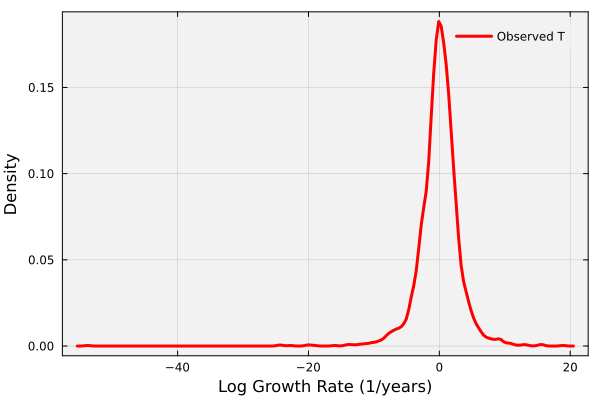

In [11]:
let
    density(log_growth_array, label="Observed $(random_firm_ticker)", lw=3, c=:red)
    xlabel!("Log Growth Rate (1/years)", fontsize=18)
    ylabel!("Density", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

### Is the observed distribution approximately normal? 
Let's use the Anderson-Darling test to quantify how well the log growth rate distribution fits a normal distribution.

> __Anderson–Darling test:__ The Anderson–Darling (AD) test is a statistical test of whether a given sample of data is drawn from a specified probability distribution. It is a type of goodness-of-fit test that compares the empirical cumulative distribution function of the sample data to the cumulative distribution function of the specified distribution. The AD test is particularly sensitive to differences in the tails of the distributions, making it useful for detecting deviations from the assumed distribution in those regions.

> __Null hypothesis:__ The Anderson–Darling test examines the null hypothesis that the data in vector $x$ come from the distribution $d$ against the alternative hypothesis that the sample is not drawn from $d$. This test reports a p-value, the probability that, assuming the null hypothesis is true (your data really are i.i.d. from $d$), the AD test statistic would be at least as extreme as the one computed from your data. 

So, let's run the test on the log growth rate data for our randomly selected firm.

In [12]:
let
    # initialize -
    μ = log_growth_array; # get the log growth array for the randomly selected firm
    d = fit_mle(Normal, μ); # fit the distribution using maximum likelihood estimation

    # TODO: Uncomment the line below to perform the Anderson-Darling test
    # TODO: reject the null hypothesis => NOT from a normal distribution
    # TODO: A^2 big => data CDF does not fit theoretical CDF well
    ad_test_normal = HypothesisTests.OneSampleADTest(μ, d);
    
end

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-06

Details:
    number of observations:   2766
    sample mean:              -0.03884700012497798
    sample SD:                3.2918389357846847
    A² statistic:             56.64945531377688


Is the Anderson-Darling result consistent with our expectations: Is the observed growth rate normally distributed?

In [13]:
is_observed_growth_rate_distribution_normal = false; # set to true if normal, false otherwise

### Compute binomial model parameters
Using the `log_growth_array::Array{Float64,1}`, we compute the expected magnitude of an up move $\bar{u}$, the expected magnitude of a down move $\bar{d}$, and the estimated probability $\bar{p}$ of an up move by passing the return data to [a `RealWorldBinomialProbabilityMeasure` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.RealWorldBinomialProbabilityMeasure), which returns the $(u,d,p)$ tuple.

> __Syntax sugar__: Behind the scenes, this call points to a private function that computes $\bar{u}$, $\bar{d}$, and $\bar{p}$ by analyzing the growth rate time series data in the `log_growth_array::Array{Float64,1}` variable. Although it appears we are using a type as a function name, we are actually invoking a callable constructor—this is a useful Julia feature!

What values did we obtain for our randomly selected firm?

In [14]:
(ū,d̄,p̄) = let

    # initialize -
    u = nothing; 
    d = nothing; 
    p = nothing; 

    # TODO: Uncomment the line below to compute the RWPM parameters for the randomly selected firm
    (u,d,p) = (RealWorldBinomialProbabilityMeasure())(log_growth_array; Δt = Δt)
    
    (u,d,p); # return
end;

Make a table for the binomial lattice parameters:

In [15]:
let

    # initialize -
    df = DataFrame();

    row_df = (
        ticker = random_firm_ticker,
        upfactor = ū,
        downfactor = d̄,
        probability = p̄,
    );
    push!(df, row_df);

      # display the table -
    pretty_table(df, backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact));    
    
end

 -------- ---------- ------------ -------------
  ticker   upfactor   downfactor   probability 
  String    Float64      Float64       Float64 
 -------- ---------- ------------ -------------
       T    1.00819     0.991245      0.512654
 -------- ---------- ------------ -------------


### Build binomial lattice model using historical parameters
Let's construct an instance of [the `MyBinomialEquityPriceTree` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree) using the estimated values for the parameters ($\bar{u}$, $\bar{d}$, $\bar{p}$) from above. 

This enables us to calculate the prices and probabilities in the tree. We store the populated model in the variable `random_test_model` for future use.

First, specify the `start_index::Int64` as the trading day index in the dataset, which will serve as the tree's starting point or `L = 0`. For reproducibility, let's hard-code this value as `start_index = 1187`, which corresponds to the trading day `2018-09-19` for our dataset.

In [16]:
start_index = 1187; # DO NOT CHANGE hardcoded start-time for reproducibility
stop_index = start_index + TSIM # TSIM defines the number of trading days to simulate
println("Visualize Firm-$(random_firm_index) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-361 between trading days (1187 -> 1229)


Next, let's build and populate the binomial lattice model using the estimated parameters and the initial share price $S_{0}$, which we set as the volume-weighted average price (VWAP) on the `start_index` trading day.

We save the populated model in the `random_test_model::MyBinomialEquityPriceTree` variable:

In [17]:
random_test_model = let

    # initialize -
    model = nothing;
    Sₒ = random_firm_data[start_index, :volume_weighted_average_price]; # set the initial share price
    
    
    # TODO: Uncomment the line below and re-run this cell to build and populate the binomial equity price tree model
    # TODO: using the (ū, d̄, p̄) values computed above (real-world parameters)
     model = build(MyBinomialEquityPriceTree, (
        u = ū, d = d̄, p = p̄)) |> (model -> populate(model, Sₒ = Sₒ, h = TSIM));
    
    
    model; # return
end;

What's in the `random_test_model::MyBinomialEquityPriceTree` instance?

In [18]:
typeof(random_test_model) |> T-> fieldnames(T)

(:u, :d, :p, :μ, :T, :connectivity, :levels, :ΔT, :data)

You can check out the fields using the dot syntax, for example: let's look at the data:

In [19]:
random_test_model.data

Dict{Int64, MyBiomialLatticeEquityNodeModel} with 946 entries:
  719 => MyBiomialLatticeEquityNodeModel(34.4798, 0.105071, nothing, nothing)
  699 => MyBiomialLatticeEquityNodeModel(25.639, 4.80635e-8, nothing, nothing)
  831 => MyBiomialLatticeEquityNodeModel(38.4581, 0.00327388, nothing, nothing)
  319 => MyBiomialLatticeEquityNodeModel(29.4747, 0.00176387, nothing, nothing)
  687 => MyBiomialLatticeEquityNodeModel(31.4212, 0.0688089, nothing, nothing)
  185 => MyBiomialLatticeEquityNodeModel(30.5495, 0.00901043, nothing, nothing)
  823 => MyBiomialLatticeEquityNodeModel(44.0422, 2.09778e-8, nothing, nothing)
  420 => MyBiomialLatticeEquityNodeModel(33.1447, 0.148112, nothing, nothing)
  525 => MyBiomialLatticeEquityNodeModel(26.3412, 1.08242e-7, nothing, nothing)
  365 => MyBiomialLatticeEquityNodeModel(32.6086, 0.135672, nothing, nothing)
  638 => MyBiomialLatticeEquityNodeModel(38.8475, 0.00109567, nothing, nothing)
  263 => MyBiomialLatticeEquityNodeModel(33.776, 0.16104, nothing

### Visualize binomial lattice price simulation
An obvious question is: How well does the binomial lattice model simulate the actual share price? Let's visualize the results for our randomly selected firm, over the time interval defined by `start_index` and `stop_index`.

> __What are we plotting?__  We'll compute the expected value and the variance of the simulated price as a function of time, i.e., at each level in the tree using the local [`𝔼(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl) functions. We'll compare these values with the price observed in the market.

__Unhide__ the code block below to see how we plotted the model simulated expected value and variance and the observed prices for your randomly selected firm using a binomial lattice model.

> __What do we see?__ The dashed line represents the expected share price predicted by the lattice model, while the shaded regions denote levels of uncertainty $\mu\pm{z}\cdot\sigma$ for $z=$ `1.0, 1.96, 2.576`. The solid red line with circles represents the [observed VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for the selected firm and date range.

Depending upon the ticker we've selected, the observed price (red line with points) may or may not lie within the $\pm\,{z}\cdot\sigma$ confidence ranges, where `z = {1, 1.96, 2.576}` are shown in progressively lighter shades of blue. The dashed dark blue line shows the expected value.

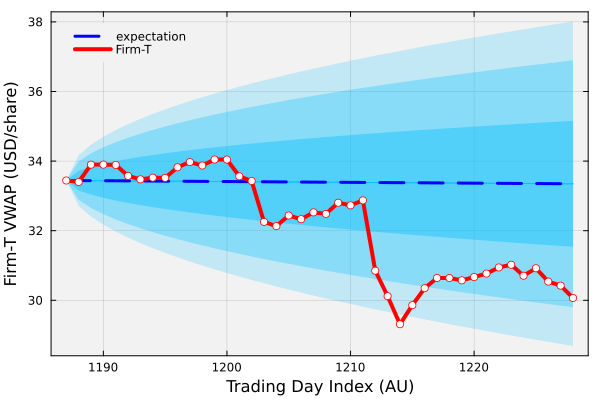

In [20]:
let 

    levels = [k for k ∈ 0:(TSIM-1)]
    expectation = 𝔼(random_test_model, levels); # compute the expected value
    variance = Var(random_test_model, levels); # compute the variance


    # initialize -
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

    T_range = range(start_index,stop=stop_index-1,step=1) |> collect 
    T_sim = T_range*Δt .- Δt

    plot(T_range, expectation[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(T_range, expectation[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(T_range, expectation[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(T_range, expectation[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(T_range, expectation[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(T_range, expectation[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(T_range, expectation[:,2],c=:blue, lw=3,ls=:dash, label="expectation")
    plot!(T_range, random_firm_data[levels .+ start_index, :volume_weighted_average_price],  
        lw=4, c=:red, label="Firm-$(random_firm_ticker)", legend = :topleft)
    scatter!(T_range, random_firm_data[levels .+ start_index, :volume_weighted_average_price], label="", 
        msc=:red, mc=:white)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);

    xlabel!("Trading Day Index (AU)", fontsize=18)
    ylabel!("Firm-$(random_firm_ticker) VWAP (USD/share)", fontsize=18)
end

In [21]:
do_I_see_price_simulation_figure = true; # set to true if you see the price simulation figure above, otherwise set to false

### Was this a successful simulation?
Determining whether a model accurately represents data can be done in various ways, but we will utilize a simple, straightforward functional test. 

> __Functional test__
> 
> * __Success__: If the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$), then the model is deemed a `success.`
> * __Failure__: However, if the actual price exceeds the given bounds __at any point__, the simulation is considered a `failure.`
>
> So, did we succeed or fail?

We save the result of this functional test in the `was_simulation_successful::Bool` variable. 

In [22]:
was_simulation_successful = let

    # initialize -
    was_simulation_successful = nothing;
    levels = [k for k ∈ 0:(TSIM-1)]
    expectation = 𝔼(random_test_model, levels); # compute the expected value
    variance = Var(random_test_model, levels); # compute the variance

    z = 2.576 # If you wanted a tighter confidence interval, you could change this value
    L = expectation[:,2] .- z*sqrt.(variance[:,2])
    U = expectation[:,2] .+ z*sqrt.(variance[:,2])
    
    # check the bounds: if below L, or above U then simulation failed
    was_simulation_successful = true;
    for k ∈ 1:TSIM

        price_value = random_firm_data[start_index+k-1,:volume_weighted_average_price];
        if (price_value < L[k]) || (price_value > U[k])
            was_simulation_successful = false;
            break;
        end
    end

    was_simulation_successful; # return
end;

In [23]:
println("Was the $(random_firm_ticker) simulation between days ($(start_index) -> $(stop_index)) successful? $(was_simulation_successful)")

Was the T simulation between days (1187 -> 1229) successful? false


___

## Task 3: Check the Stylized Facts for the Binomial Lattice Model
In this task, we will evaluate whether our binomial lattice model can replicate the well-known stylized facts of equity returns: heavy tails, vanishing autocorrelation, and volatility clustering. 

> __Stylized Facts of Binomial Returns:__ We already know from lecture that the binomial lattice model can replicate the vanishing autocorrelation stylized fact, but __not__ the heavy tails or volatility clustering stylized facts. Let's verify the autocorrelation function for our simulated growth rates to demonstrate this.

### Single step growth rates
We know (from our analysis of the data) that the one-step growth rates $\{\mu_{2},\mu_{3},\dots,\mu_{T}\}$ are __approximately__ independent and identically distributed (i.i.d.) random variables. Thus, the autocorrelation function for the growth rates should be __approximately__ zero for all lags $\tau > 1$. The growth rate $\mu_{j,j-1}$ between two consecutive time periods $j-1$ and $j$ is given by:
$$
\boxed{
    \begin{align*}
    \mu_{j,j-1}
    & = \frac{1}{\Delta t}\Big[X_j\ln u + (1-X_j)\ln d\Big] \\
    & = \frac{1}{\Delta t}\Big[\ln d + X_j\ln\!\Big({u}/{d}\Big)\Big]\quad\blacksquare
    \end{align*}
}
$$
where $X_j\sim\texttt{Bernoulli}(p)$. We'll use this expression to generate a $T-1$ length sequence of single step growth rates $\{\mu_{2},\mu_{3},\dots,\mu_{T}\}$ by simulating $T-1$ independent Bernoulli trials. We'll save the growth rate sequence in the `single_step_simulated_growth_array::Array{Float64,1}` variable.

In [24]:
single_step_simulated_growth_array = let

    # initialize -
    u = ū # up factor
    d = d̄ # down factor
    p = p̄ # probability of up movement
    T = maximum_number_trading_days; # total number of trading days in the dataset
    day = Bernoulli(p); # initialize a Bernoulli random variable
    simulated_growth_array = Array{Float64}(undef, T - 1);

    # simulate the growth rates
    for j ∈ 1:(T - 1)

        # everyday is a random Bernoulli trial
        Xⱼ = rand(day) == true ? 1 : 0 # did day j go up (1) or down (0)?
        simulated_growth_array[j] = (1/Δt)*(log(d) + Xⱼ*log(u/d)) # compute the growth rate
    end

    simulated_growth_array; # return -
end;

So what have we done here? 

> __Simulation:__ We simulated $T-1$ independent Bernoulli trials, where each trial results in an `up` move with probability $p$ and a `down` move with probability $1-p$. For each trial, we computed the corresponding growth rate $\mu_{j,j-1}$ using the expression above. The result is a sequence of $T-1$ growth rates stored in the `single_step_simulated_growth_array::Array{Float64,1}` variable.

Before we analyze the autocorrelation function for the simulated growth rates, let's compute the expected value and variance of the single-step growth rates using the expressions we derived in class. The expected value and the variance expressions that we derived for the one-step growth rate are given by:
$$
\begin{align*}
\mathbb{E}[\mu_{j,j-1}] & = \frac{1}{\Delta t}\Big[p\ln u + (1-p)\ln d\Big]\\
\mathrm{Var}(\mu_{j,j-1}) & = \frac{p(1-p)}{\Delta t^{\,2}}\Big[\ln\!\Big(\frac{u}{d}\Big)\Big]^2
\end{align*}
$$
Let's compare the theoretical and simulated values for the expected value and variance of the single-step growth rate.

In [25]:
let

    # initialize -
    df = DataFrame(); # will hold the results for the table.
    expected_value_simulated = nothing;
    expected_value_theoretical = nothing;
    variance_simulated = nothing;
    variance_theoretical = nothing;

    # TODO: Uncomment the lines below and re-run this cell to compute the expected value and variance for the simulated growth rates
    expected_value_simulated = mean(single_step_simulated_growth_array);
    expected_value_theoretical = (1/Δt)*(p̄*log(ū) + (1-p̄)*log(d̄))
    variance_simulated = var(single_step_simulated_growth_array);
    variance_theoretical = (p̄*(1-p̄)/(Δt^2))*(log(ū/d̄))^2

    # package the results into a DataFrame, and display the results as a table -
    row_df = (
        Metric = "Expected Value", 
        Simulated = expected_value_simulated,
        Theoretical = expected_value_theoretical,
        rtol_percent = 100*abs((expected_value_simulated - expected_value_theoretical)/(expected_value_theoretical))
    )
    push!(df, row_df)

    row_df = (
        Metric = "Variance", 
        Simulated = variance_simulated,
        Theoretical = variance_theoretical,
        rtol_percent = 100*abs((variance_simulated - variance_theoretical)/(variance_theoretical))
    )
    push!(df, row_df)

    # display the table -
    pretty_table(df, backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact));
end

 ---------------- ------------ ------------- --------------
          Metric    Simulated   Theoretical   rtol_percent 
          String      Float64       Float64        Float64 
 ---------------- ------------ ------------- --------------
  Expected Value   -0.0188683    -0.0265883        29.0354
        Variance      4.55757       4.55682      0.0165408
 ---------------- ------------ ------------- --------------


__Results:__ When I ran the code above, my theoretical and simulated values for the variance of the single-step growth rate were close, but the expected values were not as close as I would have expected. Thus, I'm curious about what the single-step growth rate distribution looks like. Let's visualize it.

__Unhide__ the code block below to see how we visualized the single-step growth rate sequence from our binomial lattice model. __Note:__ this is a Kernel Density Estimate (KDE) plot, which is a smoothed version of a histogram.

(f₋, f₊) = (0.48553868402024586, 0.5144613159797542)


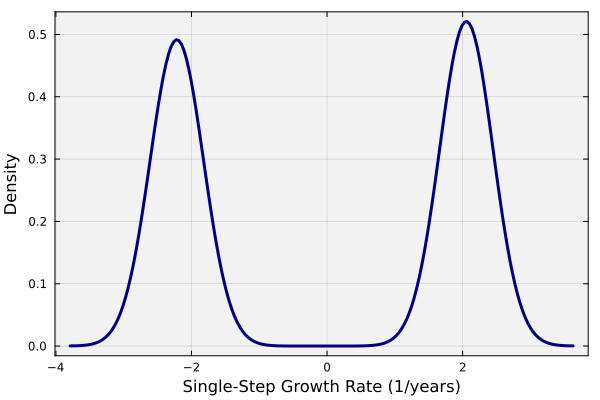

In [26]:
let
    f₋ = findall(x-> x < 0.0, single_step_simulated_growth_array) |> length |> l-> l/(maximum_number_trading_days - 1)
    f₊ = findall(x-> x > 0.0, single_step_simulated_growth_array) |> length |> l-> l/(maximum_number_trading_days - 1)
    @show f₋, f₊ # fraction: down, up

    # initialize - 
    density(single_step_simulated_growth_array, label="", lw=3, c=:navy)
    xlabel!("Single-Step Growth Rate (1/years)", fontsize=18)
    ylabel!("Density", fontsize=18)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

In [27]:
do_I_see_single_step_growth_rate_distribution_figure = true; # set to true if you see a distribution of single-step growth rates

### Discussion Questions
1. Wow, this plot initially seems strange! Why do two peaks make sense given the binomial lattice model?
2. Why is the variance of the single-step growth rate distribution closer to the theoretical value than the expected value?
3. Suppose we wanted to make this more realistic. What changes would you make to a lattice model to make the single-step growth rate distribution more realistic?

In [28]:
# Two peaks make sense when given the binomial lattice model as it represents 
#the two different outcomes that can happen. 
#The variances of the single-step growth rate distribution is closer to 
#the therotical value than the expected as the data set is still the same so the variance 
#number is less likely to change while we don't know if the security is moving up or down 
#so the expected value will be a lot more different. If we wanted to make the model more 
#realistic, the can include more parameters on different securities relationship to one another. 

In [29]:
did_I_answer_discussion_questions_1 = true; # set to true if you answered question 1

### Autocorrelation Function
Ok, so we have a sequence of single-step growth rates generated by our binomial lattice model. Let's check if this single-step growth rate sequence has a vanishing autocorrelation function.

> __Why do we care about the autocorrelation function?__ If there is correlation between growth rates at different times, we could predict future growth rates based on past growth rates. This would imply that the market is not a random walk, which contradicts the efficient market hypothesis. However, if the autocorrelation function is approximately zero for all lags $\tau > 1$, then the growth rates are independent, and the market behaves like a random walk.

__Unhide__ the code block below to see how we computed and visualized the autocorrelation function for the single-step growth rate sequence generated by our binomial lattice model.

If the autocorrelation (red line) is approximately zero (between the 99.9\% confidence interval) for all lags $\tau > 1$, then the single-step growth rates are independent, and the binomial lattice model replicates the (approximately) vanishing autocorrelation stylized fact of equity returns.

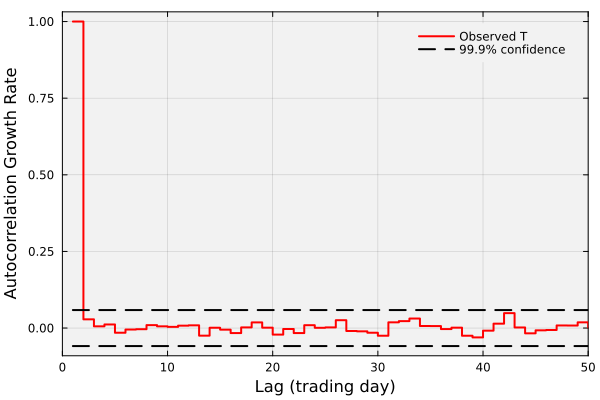

In [30]:
let

    # generate a random index -
    number_of_steps = maximum_number_trading_days - 1;
    max_number_of_steps_x = 50 # how many lags to visualize
    X = single_step_simulated_growth_array;
    
    plot(autocor(X, (0:(number_of_steps - 1) |> collect)), label="Observed $(random_firm_ticker)", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, 
        linetype=:steppost, xlims=(0,max_number_of_steps_x))

    LINE = (3.09/sqrt(number_of_steps))*ones(number_of_steps-1);
    plot!(LINE, label="99.9% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation Growth Rate", fontsize=18)
end

__Reminder__: Ignore the first lag, i.e., $\tau = 0$, since the autocorrelation at lag zero is always one (by definition).

In [31]:
does_my_autocorrelation_function_vanish = true; # set to true if the autocorrelation function vanishes for all lags > 1

### Multi-step Binomial Growth Rate Distribution
The single-step growth rate distribution is a discrete random variable that can take on only two values, corresponding to an `up` move or a `down` move. However, we made a claim in the lecture notes that the multiple step growth rate distribution approaches a normal distribution as the number of steps increases. Let's investigate this claim.

> __Claim:__ The multi-step growth rate distribution $\mu_{T}$ is a linear transformation of a binomially distributed variable $k$. As $T \to \infty$, the distribution of $\mu_{T}$ converges to a normal distribution by the Central Limit Theorem, which has lighter tails than the empirical return distributions observed in financial markets. Let's check this claim.

Suppose we consider multiple step growth rates, i.e., intervals that span $t=0\rightarrow{T}$ in timesteps of length $\Delta{t}$, where $T=i\Delta{t}$ for $i=1,2,\dots$. Then, the multi-step growth rate $\mu_{T}$ expression for a binomial process is given by (taken from lecture notes): 
$$
\boxed{
\mu_{T} = \left(\frac{1}{\Delta{t}}\right)\;\Bigl[k\ln\left(\frac{u}{d}\right)+i\ln(d)\Bigr] \quad\text{where}\;k\sim \texttt{Binomial}(i,p)
}
$$

Let's simulate the multi-step growth rate distribution for our randomly selected firm. 

__Unhide__ the code block below to see how we simulated the multi-step growth rate distribution. We simulate $i$ steps, `number_of_trials` times. In other words, we are looking at `number_of_trials` multi-step growth rates, each computed over `i` steps.

We'll save the data in the `multiple_step_simulated_growth_array::Array{Float64,1}` variable.

In [38]:
multiple_step_simulated_growth_array = let

    # initialize -
    u = ū
    d = d̄
    p = p̄
    i = 190; # number of days we are simulating
    number_of_trials = 1000; # number of trials to simulate (number of i length sequences)
    day = Binomial(i, p); # initialize a Binomial random variable
    simulated_growth_array = Array{Float64}(undef, number_of_trials);
    
    # main loop: simulate the growth rates
    for j ∈ 1:number_of_trials
        
        # everyday is a random Bernoulli trial
        Xⱼ = rand(day)
        simulated_growth_array[j] = (1/(Δt))*(rand(day)*log(u/d)+i*log(d))
    end

    simulated_growth_array; # return -
end;

__Unhide__ the code block below to see how we visualized the multi-step growth rate sequence from our binomial lattice model.

So what do we see? The blue line is a kernel density estimate (KDE) of the multi-step growth rate distribution generated by our binomial lattice model. The red line is a maximum likelihood estimate (MLE) fit of a normal distribution to the multi-step growth rate distribution.

Is the blue line close to the red line? If so, this supports our claim that the multi-step growth rate distribution approaches a normal distribution as the number of steps increases.

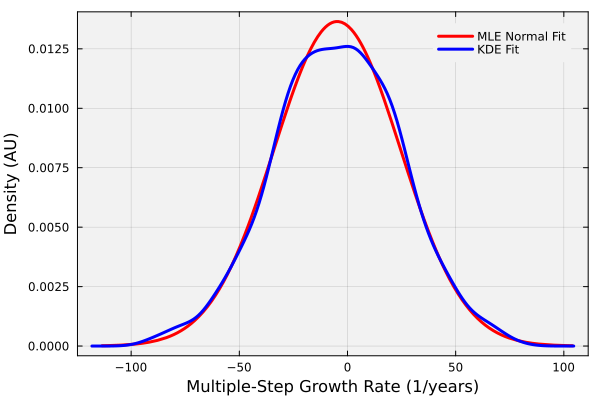

In [39]:
let
    d = fit_mle(Normal, multiple_step_simulated_growth_array);
    plot(d, c=:red, label="MLE Normal Fit", lw=3);
    density!(multiple_step_simulated_growth_array, c=:blue, label="KDE Fit", lw=3)
    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    xlabel!("Multiple-Step Growth Rate (1/years)", fontsize=18)
    ylabel!("Density (AU)", fontsize=18)
end

### Discussion Questions
1. As you change the number of steps (the `i` variable in the code block above), what do you observe? Do we approach a normal distribution (visually) as the number of steps increases?

In [33]:
# As the number of steps increases, the KDE fit looks more like the MLE normal fit. This makes sense as the number 
#of days we are looking at increases the graph will look more normal as the model is attempting to capture 
#the characteristics of the secruity. 

In [40]:
did_I_answer_discussion_question_2 = true; # true if you answered question 2

### Anderson Darling Test
The eye test is one thing, but let's get a little more rigorous. Let's use the Anderson-Darling test to quantify how well the multi-step growth rate distribution fits a normal distribution.

> __Null hypothesis:__ The Anderson–Darling test examines the null hypothesis that the data in vector $x$ come from the distribution $d$ against the alternative hypothesis that the sample is not drawn from $d$. This test reports a p-value, the probability that, assuming the null hypothesis is true (your data really are i.i.d. from $d$), the AD test statistic would be at least as extreme as the one computed from your data. 

Let's run the test.

In [41]:
let

    # initialize -
    μ = multiple_step_simulated_growth_array; # grab the multi-step growth rate array
    d = fit_mle(Normal, μ);   # fit the distribution using maximum likelihood estimation

    # TODO: Uncomment the line below to perform the Anderson-Darling test
    # TODO: reject the null hypothesis => NOT from a normal distribution
    # TODO: A^2 big => data CDF does not fit theoretical CDF well
    ad_test_normal = HypothesisTests.OneSampleADTest(μ, d);
end

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.3180

Details:
    number of observations:   1000
    sample mean:              -4.723754115389954
    sample SD:                29.241274086612297
    A² statistic:             1.0797934286348998


So what do we see?

In [36]:
does_anderson_darling_test_suggest_normality = true; # set to true if we fail to reject the null hypothesis, false otherwise

## Tests
In the code block below, we run a few tests to check if your notebook is set up and running correctly. If you see any errors, please check your code and fix the issues.

In [37]:
@testset verbose=true "PS2 CHEME 5660 Test Suite" begin

    # simple tests to make sure you completed the assignment.
    
    # growth rate tests -
    @testset verbose = true "Growth Rate Calculation" begin
        @test isnothing(log_growth_array) == false;
        @test isempty(log_growth_array) == false;
        @test length(log_growth_array) == (maximum_number_trading_days - 1)
        @test is_observed_growth_rate_distribution_normal  == false
    end

    # model tests -
    @testset verbose = true "Random Test Model" begin
        @test isnothing(random_test_model) == false;
        @test isempty(random_test_model.data) == false;
        @test isempty(random_test_model.connectivity) == false
        @test isempty(random_test_model.levels) == false;
    end
    
    # figure tests -
    @testset verbose = true "Figures, Tables and DQs" begin
        @test do_I_see_price_simulation_figure == true;
        @test do_I_see_single_step_growth_rate_distribution_figure == true
        @test did_I_answer_discussion_questions_1 == true
        @test did_I_answer_discussion_question_2  == true
        @test isnothing(was_simulation_successful) == false;
        @test was_simulation_successful == true || was_simulation_successful == false;
    end

    # stylized facts -
    @testset verbose = true "Stylized Facts" begin
        @test isnothing(does_my_autocorrelation_function_vanish) == false
        @test does_my_autocorrelation_function_vanish == true
        @test isnothing(does_anderson_darling_test_suggest_normality) == false
        @test does_anderson_darling_test_suggest_normality == true
    end
end

Growth Rate Calculation: Test Failed at /Users/jeffreyvarner/Desktop/julia_work/CHEME-5660-Fall-2025/PS2-CHEME-5660-TEMPLATE-Fall-2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y132sZmlsZQ==.jl:7
  Expression: isnothing(log_growth_array) == false
   Evaluated: true == false

Stacktrace:
 [1] macro expansion
   @ ~/.julia/juliaup/julia-1.11.6+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Test/src/Test.jl:680 [inlined]
 [2] macro expansion
   @ ~/Desktop/julia_work/CHEME-5660-Fall-2025/PS2-CHEME-5660-TEMPLATE-Fall-2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y132sZmlsZQ==.jl:7 [inlined]
 [3] macro expansion
   @ ~/.julia/juliaup/julia-1.11.6+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Test/src/Test.jl:1709 [inlined]
 [4] macro expansion
   @ ~/Desktop/julia_work/CHEME-5660-Fall-2025/PS2-CHEME-5660-TEMPLATE-Fall-2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y132sZmlsZQ==.jl:7 [inlined]
 [5] macro expansion
   @ ~/.julia/juliaup/julia-1.11.6+0.aarch64.a

TestSetException: Some tests did not pass: 0 passed, 11 failed, 7 errored, 0 broken.

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy, is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.